In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(rc={"figure.figsize": (16, 5)})
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None
pd.options.mode.chained_assignment = None


In [4]:
bike_dtypes = {
    "ANGELEGT_AM": "object",
    "TATZEIT_ANFANG_DATUM": "object",
    "TATZEIT_ANFANG_STUNDE": "int64",
    "TATZEIT_ENDE_DATUM": "object",
    "TATZEIT_ENDE_STUNDE": "int64",
    "LOR": "object",
    "SCHADENSHOEHE": "int64",
    "VERSUCH": "object",
    "ART_DES_FAHRRADS": "object",
    "DELIKT": "object",
    "ERFASSUNGSGRUND": "object",
}

lor_ort_dtypes = {
    "spatial_name": "object",
    "OTEIL": "object",
    "BEZIRK": "object",
    "FLAECHE_HA": "float64",
}

lor_bzr_dtypes = {
    "BZR_ID": "object",
    "BZR_NAME": "object",
    "BEZ": "object",
    "GROESSE_m2": "float64",
}


In [5]:
path = Path().parent.absolute()
bike_path = path / "data" / "Fahrraddiebstahl.csv"
lor_ort_path = path / "data" / "lor_ortsteile.csv"
lor_bzr_path = path / "data" / "lor_bezirksregionen_2021.csv"


with open(bike_path, "rb") as file:
    bike_data = pd.read_csv(file, encoding="latin1", dtype=bike_dtypes)

with open(lor_ort_path, "rb") as file:
    lor_ort_data = pd.read_csv(
        file,
        encoding="utf-8",
        dtype=lor_ort_dtypes,
        usecols=["spatial_name", "BEZIRK"],
    )

with open(lor_bzr_path, "rb") as file:
    lor_bzr_data = pd.read_csv(
        file,
        encoding="utf-8",
        dtype=lor_bzr_dtypes,
        usecols=["BZR_ID", "BZR_NAME", "BEZ", "GROESSE_m2"],
    )


In [6]:
# Aufbereitung von timevalues
bike_data["ANGELEGT_AM"] = pd.to_datetime(bike_data["ANGELEGT_AM"], dayfirst=True)
bike_data["TATZEIT_ANFANG_DATUM"] = pd.to_datetime(
    bike_data["TATZEIT_ANFANG_DATUM"], dayfirst=True
) + pd.to_timedelta(bike_data.TATZEIT_ANFANG_STUNDE, unit="h")
bike_data["TATZEIT_ENDE_DATUM"] = pd.to_datetime(
    bike_data["TATZEIT_ENDE_DATUM"], dayfirst=True
) + pd.to_timedelta(bike_data.TATZEIT_ENDE_STUNDE, unit="h")
bike_data["TATDAUER_STUNDEN"] = (
    bike_data.TATZEIT_ENDE_DATUM - bike_data.TATZEIT_ANFANG_DATUM
).astype("timedelta64[h]")

# Vorbereitung eines keys zum Join mit Bezirksübersichtstabelle
bike_data["BZR_ID"] = bike_data["LOR"].str[0:6]
lor_ort_data["spatial_name"] = lor_ort_data["spatial_name"].str[0:2]
lor_ort_data = lor_ort_data.rename(columns={"spatial_name": "BEZ"})


In [7]:
# bike_data.info()
# lor_ort_data.info()
# lor_bez_data.info()


In [8]:
merged_df = bike_data.merge(lor_bzr_data, how="left", on="BZR_ID")
merged_df = merged_df.merge(lor_ort_data, how="left", on="BEZ")
merged_df = merged_df.drop_duplicates()
del (
    bike_data,
    lor_ort_data,
    lor_ort_dtypes,
    lor_ort_path,
    lor_bzr_data,
    lor_bzr_dtypes,
    lor_bzr_path,
)


In [9]:
# Übersicht über unique values der einzelnen Spalten

# merged_df.columns.to_list()
for col in merged_df[
    [
        "VERSUCH",
        "ART_DES_FAHRRADS",
        "DELIKT",
        "ERFASSUNGSGRUND",
        "BEZIRK",
    ]
]:
    print(f"{col} : \n {merged_df[col].unique()}")


VERSUCH : 
 ['Nein' 'Unbekannt' 'Ja']
ART_DES_FAHRRADS : 
 ['Herrenfahrrad' 'Damenfahrrad' 'Mountainbike' 'diverse Fahrräder'
 'Fahrrad' 'Kinderfahrrad' 'Rennrad' 'Lastenfahrrad']
DELIKT : 
 ['Fahrraddiebstahl' 'Keller- und Bodeneinbruch']
ERFASSUNGSGRUND : 
 ['Sonstiger schwerer Diebstahl von Fahrrädern'
 'Einfacher Diebstahl von Fahrrädern'
 'Sonstiger schwerer Diebstahl in/aus Keller/Boden von Fahrrädern'
 'Einfacher Diebstahl aus Keller/Boden von Fahrrädern']
BEZIRK : 
 [nan 'Mitte' 'Steglitz-Zehlendorf' 'Tempelhof-Schöneberg' 'Pankow'
 'Spandau' 'Friedrichshain-Kreuzberg' 'Neukölln' 'Treptow-Köpenick'
 'Reinickendorf' 'Lichtenberg' 'Charlottenburg-Wilmersdorf'
 'Marzahn-Hellersdorf']


## Exploration
### Assumptions
- Inexpensive bicycles (<= 200€) are less often insured and thefts are therefore less likely to be reported to the police--> The number of unreported cases of cheap stolen bicycles cannot be estimated within the scope of this task, but is potentially high.
- Expensive bicycles (> 750€) are more often insured and thefts therefore very often lead to police registration --> the number of unreported cases of expensive stolen bicycles is potentially very small.
### Questions
- What are the absolute values of the offences?
    - Bicycle thefts in the tens of thousands.   
- What are the minima/maxima of the periods?
    - Data between 01.01.2022 and 19.02.2023

In [11]:
merged_df.groupby(["DELIKT"], dropna=False).agg(
    {
        "ANGELEGT_AM": ["count", "min", "max"],
        "TATZEIT_ANFANG_DATUM": ["min", "max"],
        "TATZEIT_ENDE_DATUM": ["min", "max"],
    }
).sort_values(by=("ANGELEGT_AM", "count"), ascending=False)


ANGELEGT_AM                        \
                                count        min        max   
DELIKT                                                        
Fahrraddiebstahl                23507 2022-01-01 2023-02-19   
Keller- und Bodeneinbruch        1055 2022-01-02 2023-02-18   

                          TATZEIT_ANFANG_DATUM                      \
                                           min                 max   
DELIKT                                                               
Fahrraddiebstahl                    2022-01-01 2023-02-19 18:00:00   
Keller- und Bodeneinbruch           2022-01-01 2023-02-17 19:00:00   

                           TATZEIT_ENDE_DATUM                      
                                          min                 max  
DELIKT                                                             
Fahrraddiebstahl          2022-01-01 00:00:00 2023-02-19 21:00:00  
Keller- und Bodeneinbruch 2022-01-02 10:00:00 2023-02-18 11:00:00

What is a reported "attempt"?
- From the following table I conclude that an "attempt" is a thwarted theft.
- Bicycle thefts are reported significantly more often than burglaries, presumably the former are generally much more common

In [10]:
merged_df.groupby("VERSUCH").agg({"SCHADENSHOEHE": ["count", "sum"]})


SCHADENSHOEHE          
                  count       sum
VERSUCH                          
Ja                   67         0
Nein              24490  25906812
Unbekannt             5      6070

In [11]:
merged_df.groupby(["DELIKT"], dropna=False).agg(
    {
        "ANGELEGT_AM": "count",
        "SCHADENSHOEHE": "sum",
        "TATDAUER_STUNDEN": ["mean", "median", "std"],
    }
).sort_values(by=("ANGELEGT_AM", "count"), ascending=False)


ANGELEGT_AM SCHADENSHOEHE TATDAUER_STUNDEN         \
                                count           sum             mean median   
DELIKT                                                                        
Fahrraddiebstahl                23507      24411249        13.455439    9.0   
Keller- und Bodeneinbruch        1055       1501633        26.056872   20.0   

                                      
                                 std  
DELIKT                                
Fahrraddiebstahl           15.296041  
Keller- und Bodeneinbruch  21.003537

#### Reported cases + damage per district in €
- Marzahn-Hellersdorf has comparatively few thefts, but a disproportionately high number of cellar burglaries (secure cellars/floors better?)
- The average reported damage amounts indicate medium- to high-value bicycle models
- Damage totals for cellar and floor burglaries generally higher than for simple thefts (is damage calculated differently here?)
- Middle seems to have the most expensive bikes on average

In [12]:
merged_df.pivot_table(
    index="BEZIRK",
    columns="DELIKT",
    aggfunc={"SCHADENSHOEHE": ["count", "sum", "median", "mean"]},
    dropna=False,
).sort_values(by=("SCHADENSHOEHE", "count", "Fahrraddiebstahl"), ascending=False)


SCHADENSHOEHE                            \
                                      count                             
DELIKT                     Fahrraddiebstahl Keller- und Bodeneinbruch   
BEZIRK                                                                  
Mitte                                  3809                       139   
Friedrichshain-Kreuzberg               3527                        96   
Pankow                                 3099                       102   
Charlottenburg-Wilmersdorf             2368                        90   
Tempelhof-Schöneberg                   2115                        76   
Neukölln                               1840                        42   
Treptow-Köpenick                       1613                        98   
Steglitz-Zehlendorf                    1463                        41   
Lichtenberg                            1281                       109   
Reinickendorf                           842                        44   
Spandau                                 672                        53   
Marzahn-Hellersdorf                     651                       153   

                                                                       \
                                       mean                             
DELIKT                     Fahrraddiebstahl Keller- und Bodeneinbruch   
BEZIRK                                                                  
Mitte                           1119.988448               1390.683453   
Friedrichshain-Kreuzberg        1034.987525               1290.239583   
Pankow                          1009.700226               1397.029412   
Charlottenburg-Wilmersdorf      1160.885135               1866.288889   
Tempelhof-Schöneberg            1002.198109               1717.052632   
Neukölln                         976.848913               1363.095238   
Treptow-Köpenick                 968.980161               1512.571429   
Steglitz-Zehlendorf              988.388927               1438.317073   
Lichtenberg                     1011.204528               1290.146789   
Reinickendorf                    980.743468               1428.863636   
Spandau                         1132.171131               1370.339623   
Marzahn-Hellersdorf              895.935484               1254.444444   

                                                                       \
                                     median                             
DELIKT                     Fahrraddiebstahl Keller- und Bodeneinbruch   
BEZIRK                                                                  
Mitte                                 850.0                     925.0   
Friedrichshain-Kreuzberg              749.0                    1000.0   
Pankow                                723.0                    1000.0   
Charlottenburg-Wilmersdorf            849.0                    1200.0   
Tempelhof-Schöneberg                  700.0                    1250.0   
Neukölln                              700.0                     900.0   
Treptow-Köpenick                      655.0                     933.0   
Steglitz-Zehlendorf                   700.0                    1000.0   
Lichtenberg                           658.0                     800.0   
Reinickendorf                         629.5                     950.0   
Spandau                               700.0                     900.0   
Marzahn-Hellersdorf                   587.0                     800.0   

                                                                       
                                        sum                            
DELIKT                     Fahrraddiebstahl Keller- und Bodeneinbruch  
BEZIRK                                                                 
Mitte                               4266036                    193305  
Friedrichshain-Kreuzberg            3650401                    123863  
Pankow                              3129061                    142497  
Charlottenburg-Wilm

- Serious bicycle theft seems to be the main reason for the theft.
- Grand bike theft = expensive bike = higher damage?
    - Does it make more sense to file a complaint because of the insurance sum?

In [13]:
merged_df.pivot_table(
    index="BEZIRK",
    columns="ERFASSUNGSGRUND",
    aggfunc={"SCHADENSHOEHE": ["count", "median"]},
).sort_values(
    by=("SCHADENSHOEHE", "count", "Sonstiger schwerer Diebstahl von Fahrrädern"),
    ascending=False,
)


SCHADENSHOEHE  \
                                                                         count   
ERFASSUNGSGRUND            Einfacher Diebstahl aus Keller/Boden von Fahrrädern   
BEZIRK                                                                           
Mitte                                                                      5.0   
Friedrichshain-Kreuzberg                                                   3.0   
Pankow                                                                     6.0   
Charlottenburg-Wilmersdorf                                                 3.0   
Tempelhof-Schöneberg                                                       4.0   
Neukölln                                                                   NaN   
Treptow-Köpenick                                                           3.0   
Steglitz-Zehlendorf                                                        4.0   
Lichtenberg                                                                3.0   
Reinickendorf                                                              NaN   
Marzahn-Hellersdorf                                                        9.0   
Spandau                                                                    NaN   

                                                               \
                                                                
ERFASSUNGSGRUND            Einfacher Diebstahl von Fahrrädern   
BEZIRK                                                          
Mitte                                                   201.0   
Friedrichshain-Kreuzberg                                199.0   
Pankow                                                  138.0   
Charlottenburg-Wilmersdorf                              150.0   
Tempelhof-Schöneberg                                    113.0   
Neukölln                                                 93.0   
Treptow-Köpenick                                         63.0   
Steglitz-Zehlendorf                                      71.0   
Lichtenberg                                              44.0   
Reinickendorf                                            42.0   
Marzahn-Hellersdorf                                      19.0   
Spandau                                                  51.0   

                                                                                            \
                                                                                             
ERFASSUNGSGRUND            Sonstiger schwerer Diebstahl in/aus Keller/Boden von Fahrrädern   
BEZIRK                                                                                       
Mitte                                                                                139.0   
Friedrichshain-Kreuzberg                                                              96.0   
Pankow                                                                               102.0   
Charlottenburg-Wilmersdorf                                                            90.0   
Tempelhof-Schöneberg                                                                  76.0   
Neukölln                                                                              42.0   
Treptow-Köpenick                                                                      98.0   
Steglitz-Zehlendorf                                                                   41.0   
Lichtenberg                                                                          109.0   
Reinickendorf                                                                         44.0   
Marzahn-Hellersdorf                                                                  153.0   
Spandau                                                                               53.0   

                                                                        \
                                                                         
ERFASSUNGSGRUND            Sonstiger schwerer Diebstahl vo

### In which value range is theft most frequently reported?
- Bicycles in the medium price range (approx. €300 - €750) seem to be most frequently reported stolen in both types of offence.

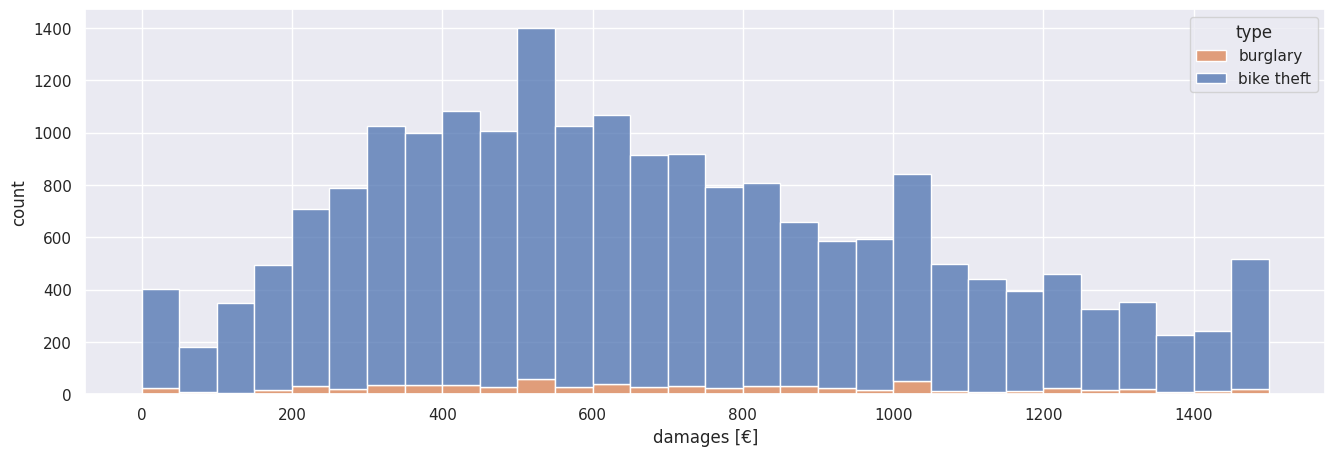

In [34]:
fig, ax = plt.subplots()
sns.histplot(
    data=merged_df,
    x="SCHADENSHOEHE",
    binrange=[0, 1500],
    binwidth=50,
    hue="DELIKT",
    multiple="stack",
    ax=ax,
)
ax.set(xlabel="damages [€]", ylabel="count")
ax.legend(title="type", labels=["burglary", "bike theft"])
plt.show()


### How long does it generally take to commit a crime?
- The graph below indicates quick thefts of less than one hour. 

NOTE: It is possible that a theft has been attributed an arbitrary duration if the duration of the offence is not known. In this case, 0 hours may have been selected as the default.

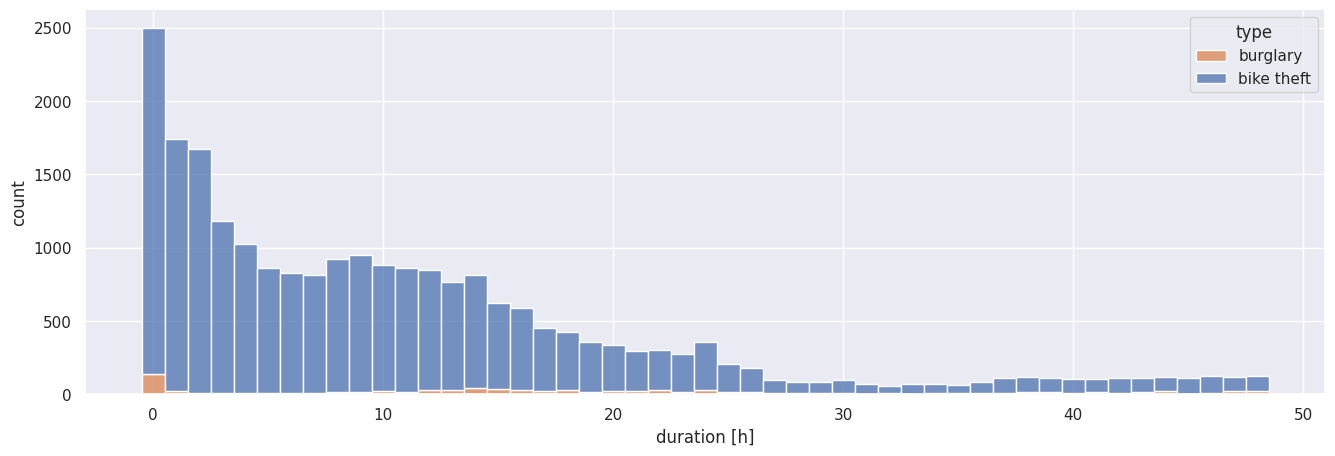

In [33]:
fig, ax = plt.subplots()
sns.histplot(
    data=merged_df,
    x="TATDAUER_STUNDEN",
    binrange=[0, 48],
    discrete=True,
    hue="DELIKT",
    multiple="stack",
)
ax.set(xlabel="duration [h]", ylabel="count")
ax.legend(title="type", labels=["burglary", "bike theft"])
plt.show()


### When do thefts generally take place?
- The most frequent thefts take place between
    - 7-9 am
    - 17-19 in the evening
- The most frequent burglaries take place between
    - 11-13 noon
    - 17-19 in the evening

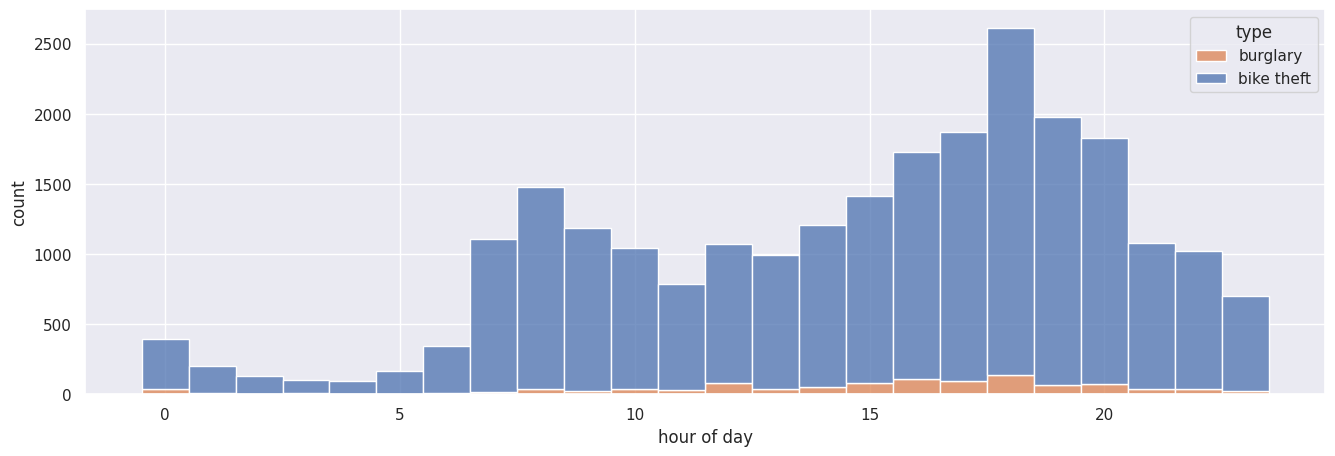

In [13]:
fig, ax = plt.subplots()
sns.histplot(
    data=merged_df,
    x="TATZEIT_ANFANG_STUNDE",
    discrete=True,
    hue="DELIKT",
    multiple="stack",
    ax=ax,
)
ax.set(xlabel="hour of day", ylabel="count")
ax.legend(title="type", labels=["burglary", "bike theft"])
plt.show()


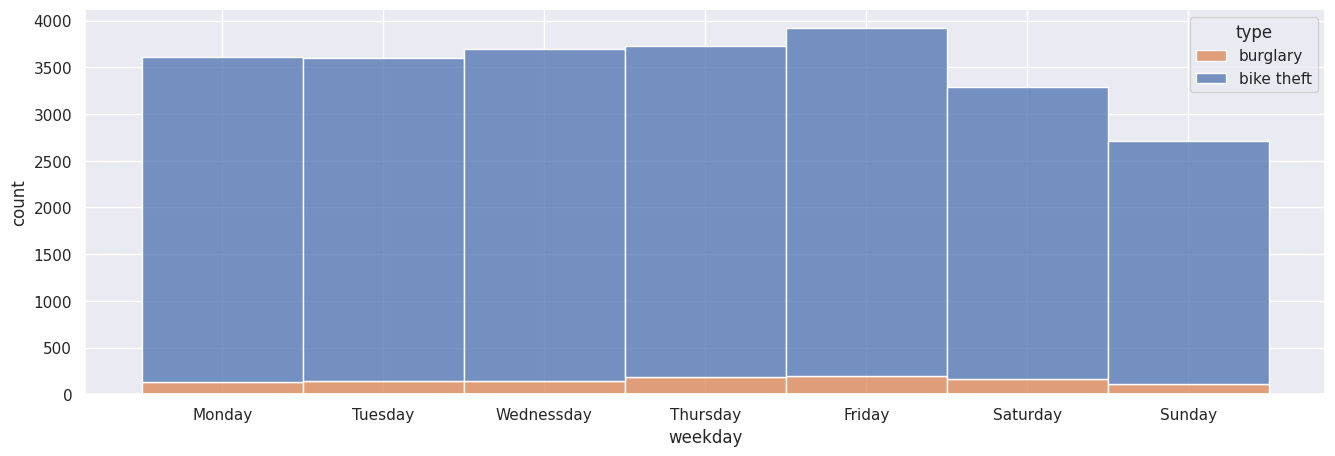

In [31]:
fig, ax = plt.subplots()
sns.histplot(
    data=merged_df,
    x=merged_df.TATZEIT_ANFANG_DATUM.dt.day_of_week,
    discrete=True,
    hue="DELIKT",
    multiple="stack",
    ax=ax,
)
ax.set_xticks(
    [0, 1, 2, 3, 4, 5, 6],
    ["Monday", "Tuesday", "Wednessday", "Thursday", "Friday", "Saturday", "Sunday"],
)
ax.set(xlabel="weekday", ylabel="count")
ax.legend(title="type", labels=["burglary", "bike theft"])
plt.show()


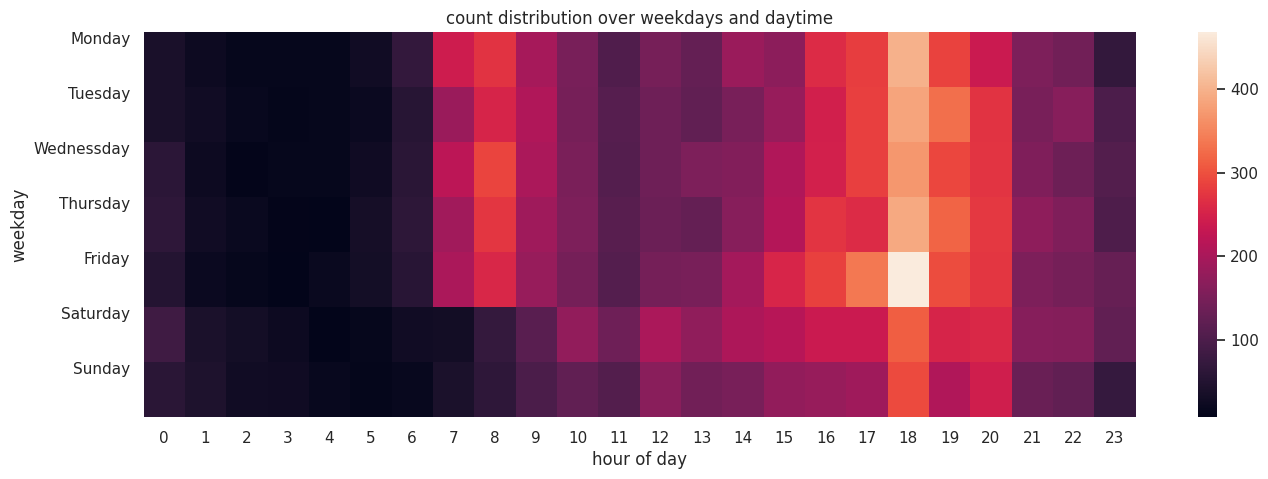

In [24]:
fig, ax = plt.subplots()
sns.heatmap(
    data=pd.DataFrame(
        {
            "day": merged_df.TATZEIT_ANFANG_DATUM.dt.day_of_week,
            "hour": merged_df.TATZEIT_ANFANG_DATUM.dt.hour,
        }
    )
    .groupby(["day", "hour"], as_index=False)
    .value_counts()
    .reset_index()
    .pivot(index="day", columns="hour", values="count")
)
ax.set_yticks(
    [0, 1, 2, 3, 4, 5, 6],
    ["Monday", "Tuesday", "Wednessday", "Thursday", "Friday", "Saturday", "Sunday"],
    rotation=0,
    va="top",
)
ax.set(
    xlabel="hour of day",
    ylabel="weekday",
    title="count distribution over weekdays and daytime",
)
plt.show()


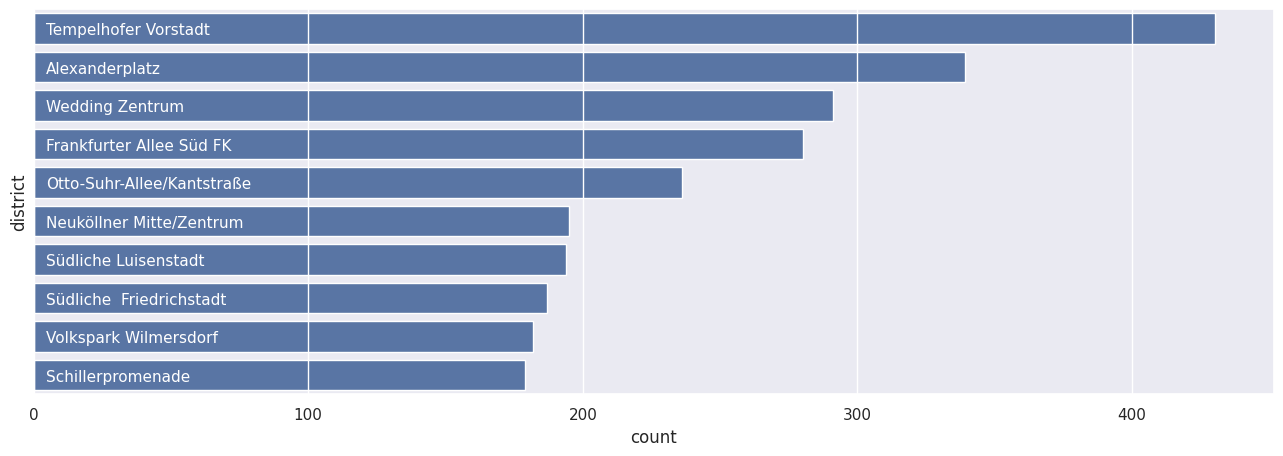

In [26]:
plot_df = merged_df[
    (merged_df.TATZEIT_ANFANG_STUNDE.isin([15, 16, 17, 18, 19, 20]))
    & (merged_df.TATZEIT_ANFANG_DATUM.dt.day_of_week.isin([0, 1, 2, 3, 4, 5]))
]
plot_df = (
    plot_df.groupby("BZR_NAME")
    .agg({"ANGELEGT_AM": "count", "SCHADENSHOEHE": "sum"})
    .sort_values(by=("ANGELEGT_AM"), ascending=False)
    .head(10)
    .reset_index()
)
with plt.rc_context({"axes.axisbelow": "line"}):
    fig, ax1 = plt.subplots()
    sns.barplot(data=plot_df, y="BZR_NAME", x="ANGELEGT_AM", ax=ax1, color="#4c72b0")
    ax1.set(xlabel="count", ylabel="district")
    ax1.set_yticklabels(plot_df.BZR_NAME, ha="left", fontdict={"color": "white"})
    ax1.yaxis.set_tick_params(pad=-15)
    plt.show()


### Which bikes are most often reported as stolen?
- In the data, the generic terms *men's* and *women's bicycles* are most frequently represented, but these could also be understood as a generic term for other types, such as mountain bike, trekking bike, etc.

In [37]:
merged_df.groupby(["ART_DES_FAHRRADS"]).agg(
    {"SCHADENSHOEHE": ["count", "sum", "max"]}
).sort_values(by=("SCHADENSHOEHE", "count"), ascending=False)


SCHADENSHOEHE                 
                          count       sum    max
ART_DES_FAHRRADS                                
Herrenfahrrad             11518  12570193   9900
Damenfahrrad               6630   6027648  10000
Fahrrad                    3391   4228172   9799
Mountainbike               1021    858683   8000
Kinderfahrrad               953    394934   1950
diverse Fahrräder           632   1262759  10000
Rennrad                     356    417124   8500
Lastenfahrrad                61    153369   9000

### Are there seasonal peak times for offences?
- Apparently there are fewer reported thefts in the cold months of Dec-March.
    - Assumption: people put unused bikes in cellars, generally ride less --> fewer casual thefts

/tmp/ipykernel_17796/4278460860.py:2: UserWarning: The palette list has more values (20) than needed (12), which may not be intended.
  sns.histplot(
/tmp/ipykernel_17796/4278460860.py:17: UserWarning: The palette list has more values (20) than needed (12), which may not be intended.
  sns.histplot(


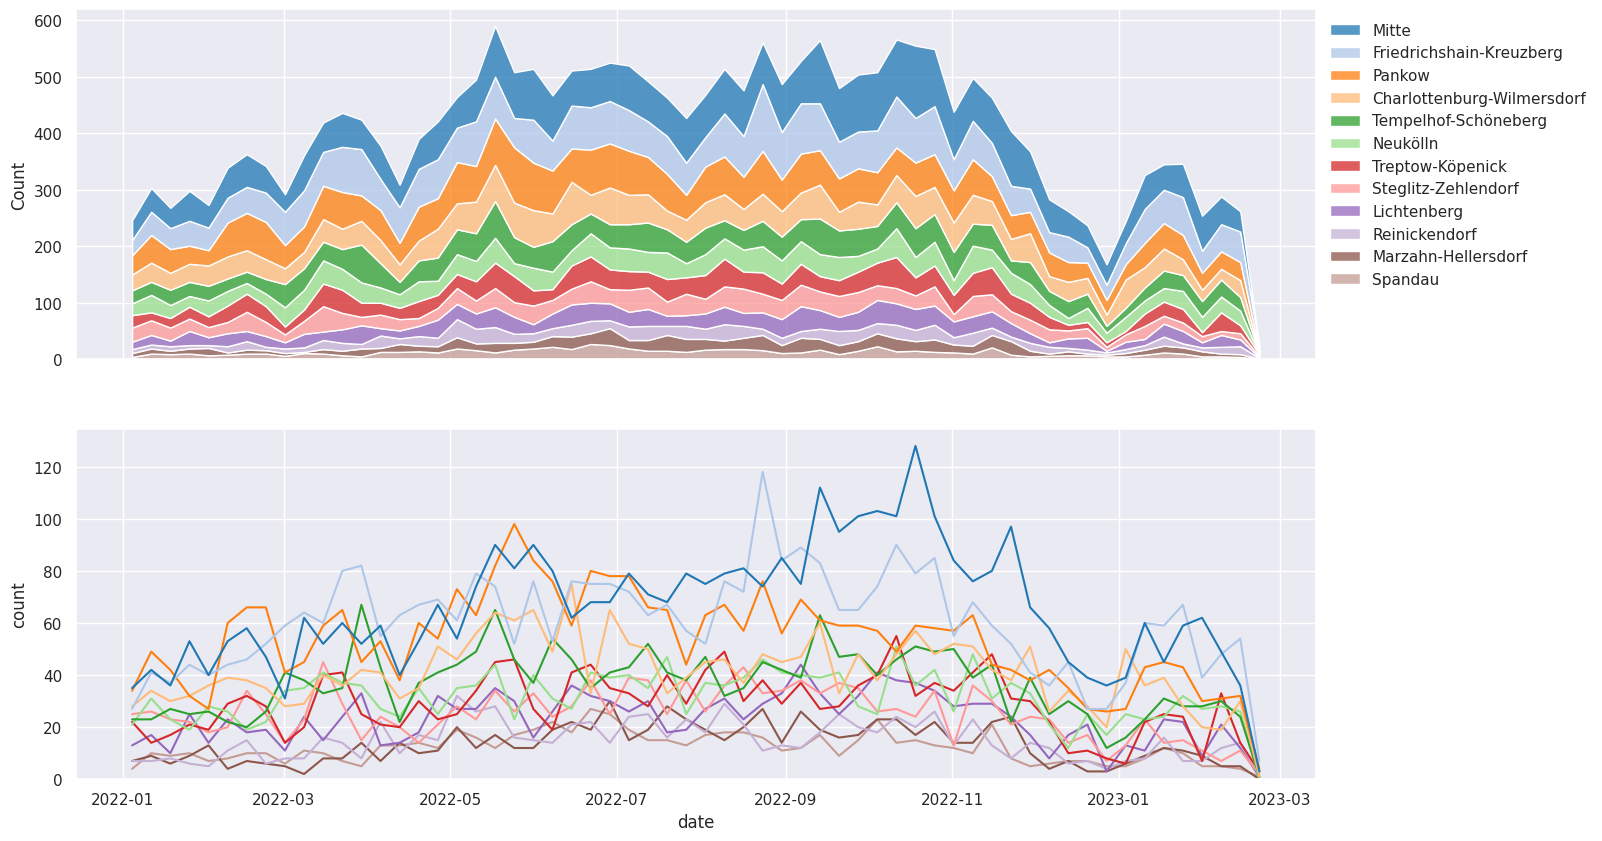

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 10))
sns.histplot(
    ax=ax1,
    data=merged_df,
    x="TATZEIT_ANFANG_DATUM",
    element="poly",
    hue="BEZIRK",
    hue_order=merged_df.groupby("BEZIRK")
    .agg({"LOR": "count"})
    .sort_values(by="LOR", ascending=False)
    .index.to_list(),
    multiple="stack",
    binwidth=7,
    palette=sns.color_palette("tab20"),
)
sns.histplot(
    ax=ax2,
    data=merged_df,
    x="TATZEIT_ANFANG_DATUM",
    element="poly",
    fill=False,
    hue="BEZIRK",
    hue_order=merged_df.groupby("BEZIRK")
    .agg({"LOR": "count"})
    .sort_values(by="LOR", ascending=False)
    .index.to_list(),
    binwidth=7,
    palette=sns.color_palette("tab20"),
    legend=False,
)
sns.move_legend(
    ax1,
    "upper left",
    bbox_to_anchor=(1, 1),
    title=None,
    frameon=False,
)
ax1.set(xlabel=None, xticklabels=[])
plt.xlabel("date")
plt.ylabel("count")
plt.show()


# Dashboard

Meaningful plots for bicycle theft monitoring:
- Trend lines, broken down weekly, are more or fewer bikes being stolen?
- Peak theft times, per day of the week? When should police officers check?

With additional data:
- Exact locations on map (streets?), where is most stolen, where should be checked most?
- How many bicycles were stolen
- How many bikes are stolen at the same time in the same place? Organised theft, or casual theft?

# Tools and Languages

Work on Ubuntu

Since the task is mostly written in a purely exploratory way, the following setup was the most time-saving.

- Python
    - setup
        - Pyenv (python-distribution manager)
        - Poetry (dependencies)
    - packages
        - Pandas for data processing and tabulation (Spark could also be an option)
        - Matplotlib and Seaborn for data visualisation
        - pathlib for handling file paths

- Libreoffice Calc for quick overview

# Pipelines

Highly dependent on the circumstances and the amount of data to be processed.

- Hosting: VM in the cloud? On-Premise?
- Loading and processing data: Python scripts 
    - Spark with Pyspark? Or simply Pandas/Polars?
- Orchestration: Airflow or Prefect
- Data storage: Postgresql? Cloud/On-Premise?
- Dashboard: Metabase? Tableau?